Ce code permet d'automatiser le rapport sur le prix au m². 

Les objets à mettre dans le rapport sont marqués par # TODO en début de cellule. (Il faut exécuter la cellule puis insérer au Latex ce qui est indiqué dans TODO)

Le code est organisé de la même manière que le rapport, les titres sont écrits dans des cellules Markdown

Executer sur l'environnement base

### A faire par l'utilisateur :
- Copier/coller les données de MeilleursAgents: https://www.meilleursagents.com/prix-immobilier/. Mettre le fichier à cet emplacement : N:\uflujek\table_rapport\Prix_m2\prix_MA_dept.xlsx (pour les départements) et N:\uflujek\table_rapport\Prix_m2\prix_MA_ville.xlsx (pour les villes)

Copier/coller directement les données dans excel et supprimer les liens hypertextes (clique droit sur la première colonne + supprimer les liens hypertextes)

### Choix des départements et villes dans les tableaux :

In [1]:
departments_to_keep = ['75', '77', '78', '91', '92', '93', '94', '95', '59', '69', '06', '13'] # A changer si nécessaire
n_plus_grandes_villes = 15 # nombre de plus grandes villes à conserver dans le tableau

In [2]:
import os
import pandas as pd
import time
import numpy as np
import textwrap
import matplotlib.pyplot as plt
import seaborn as sns
import re
import folium
import xlsxwriter
import json
from folium.features import GeoJsonTooltip
import io
import scipy.stats as stats
from datetime import datetime
import string
import openpyxl
from openpyxl import load_workbook
from openpyxl.styles import PatternFill
from openpyxl.styles.differential import DifferentialStyle
from openpyxl.formatting.rule import Rule
from openpyxl.utils import get_column_letter
from openpyxl.utils.dataframe import dataframe_to_rows
import shutil
from openpyxl.drawing.image import Image
from openpyxl.styles import Font, Color, PatternFill, Border, Side
from openpyxl.utils.cell import coordinate_from_string, column_index_from_string
import warnings
import pathlib
import pyodbc
import pandasql as ps
warnings.filterwarnings('ignore')
sns.set_theme()

## IMPORT

In [3]:
SERVEUR = 'ISIS'
DATABASE = 'BIENS'
SCHEMA = 'dbo'




PROD_PWD = 'Est1mat1on@b1ens_Dev%'
PROD_ID = 'Ebiens_Batch'



conn = pyodbc.connect('DRIVER={SQL Server};'
                                f'SERVER={SERVEUR};'
                                f'DATABASE={DATABASE};'
                                f'UID={PROD_ID};'
                                f'PWD={PROD_PWD};')
df_prix_m2 = pd.read_sql_query(
    f"""SELECT DISTINCT *
    FROM BIENS.dbo.PRIX_M2
    WHERE MAILLE_GEO = 'DEPT' AND DIC_NAME LIKE '%cty_%_%m'"""
    ,conn)

In [4]:
df = pd.read_csv(r'N:\uflujek\dept_population.csv', sep =';', encoding ='latin-1')
df['num_département'] = df['num_département'].astype(str)
df['population'] = pd.to_numeric(df['population'], errors='coerce')
df['num_département'] = df['num_département'].apply(lambda x: x.zfill(2))
df_prix_m2 = pd.merge(df, df_prix_m2, left_on='num_département', right_on='VAL_MAILLE_GEO', how='inner')

## Prix au m² des départements français

### Carte

In [5]:
# TODO : ajouter les cartes au latex, chemin : N:\\uflujek\\prix_m2\\ma_carte_prix_m2_dept_{type_bien}.html

df_final = pd.DataFrame()
list_tables = [] 



requete_sql = f"""
SELECT  *
FROM df_prix_m2"""
df_prix_m2_dept = ps.sqldf(requete_sql, locals())

df_prix_m2_dept= df_prix_m2_dept.rename(columns={' nom_département' : 'nom_département'})
df = df_prix_m2_dept

df_3m = df[(df['DIC_NAME'] == '__pm2_cty_3m') & (df['CD_TYP_BIEN'] != 'ALL') | 
            (df['DIC_NAME'] == '__pm2_cty_comp_3m') & (df['CD_TYP_BIEN'] == 'ALL')]
df_6m = df[((df['DIC_NAME'] == '__pm2_cty_6m') & (df['CD_TYP_BIEN'] != 'ALL')) | 
            ((df['DIC_NAME'] == '__pm2_cty_comp_6m') & (df['CD_TYP_BIEN'] == 'ALL'))]


df_3m = df_3m.rename(columns={'MEAN': 'mean_3m', 'NB_BIENS': 'nb_bien_3m'})
df_6m = df_6m.rename(columns={'MEAN': 'mean_6m_3m', 'NB_BIENS': 'nb_bien_6m'})
df_merged = pd.merge(df_3m, df_6m, on=['nom_département', 'CD_TYP_BIEN'], how='inner')


df_merged['mean_6_m'] = (df_merged['mean_6m_3m'] * (df_merged['nb_bien_3m'] + df_merged['nb_bien_6m']) - df_merged['nb_bien_3m'] * df_merged['mean_3m']) / df_merged['nb_bien_6m']
df_6m_merged = df_merged[((df_merged['DIC_NAME_y'] == '__pm2_cty_6m') | (df_merged['DIC_NAME_y'] == '__pm2_cty_comp_6m'))]
df_prix_m2_dept= pd.merge(df_prix_m2_dept, df_6m_merged[['nom_département', 'CD_TYP_BIEN', 'mean_6_m']], on=['nom_département', 'CD_TYP_BIEN'], how='left')




df_prix_m2_dept['mean_6_m'] = df_prix_m2_dept['mean_6_m'].where(df_prix_m2_dept['DIC_NAME'].str.endswith('6m'), np.nan)
df_6m = df[(df['DIC_NAME'] == '__pm2_cty_6m') & (df['CD_TYP_BIEN'] != 'ALL') | 
            (df['DIC_NAME'] == '__pm2_cty_comp_6m') & (df['CD_TYP_BIEN'] == 'ALL')]
df_12m = df[((df['DIC_NAME'] == '__pm2_cty_12m') & (df['CD_TYP_BIEN'] != 'ALL')) | 
            ((df['DIC_NAME'] == '__pm2_cty_comp_12m') & (df['CD_TYP_BIEN'] == 'ALL'))]
df_6m = df_6m.rename(columns={'MEAN': 'mean_6m', 'NB_BIENS': 'nb_bien_6m'})
df_12m = df_12m.rename(columns={'MEAN': 'mean_12m_6m', 'NB_BIENS': 'nb_bien_12m'})
df_merged = pd.merge(df_6m, df_12m, on=['nom_département', 'CD_TYP_BIEN'], how='inner')
df_merged['mean_12_m'] = (df_merged['mean_12m_6m'] * (df_merged['nb_bien_6m'] + df_merged['nb_bien_12m']) - df_merged['nb_bien_6m'] * df_merged['mean_6m']) / df_merged['nb_bien_12m']
df_12m_merged = df_merged[((df_merged['DIC_NAME_y'] == '__pm2_cty_12m') | (df_merged['DIC_NAME_y'] == '__pm2_cty_comp_12m'))]
df_prix_m2_dept = pd.merge(df_prix_m2_dept, df_12m_merged[['nom_département', 'CD_TYP_BIEN', 'mean_12_m']], on=['nom_département', 'CD_TYP_BIEN'], how='left')
df_prix_m2_dept['mean_12_m'] = df_prix_m2_dept['mean_12_m'].where(df_prix_m2_dept['DIC_NAME'].str.endswith('12m'), np.nan)

table = df_prix_m2_dept[['nom_département', 'CD_TYP_BIEN', 'mean_6_m', 'mean_12_m', 'DIC_NAME', 'MEAN', 'NB_BIENS', 'VAL_MAILLE_GEO', 'STD']]
list_tables.append(table)
table_final = pd.concat(list_tables, ignore_index=True)


with open(r'N:\uflujek\table_rapport\Prix_m2\dep_fr.geojson') as f:
    geojson = json.load(f)


types_bien = ['ALL', 'APT', 'MAI']

for type_bien in types_bien:

    requete_sql = f"""
    SELECT  DISTINCT *
    FROM table_final
    WHERE CD_TYP_BIEN = '{type_bien}' AND DIC_NAME LIKE '%cty_%_%m' AND mean_12_m NOT NULL"""
    df = ps.sqldf(requete_sql, locals())

    for feature in geojson['features']:
        code = feature['properties']['code']
        row = df.loc[df['VAL_MAILLE_GEO'] == code]
        for col in df.columns:
            if col == 'mean_12_m' and len(row[col].values) > 0:
    
                feature['properties'][col] = f"Prix au m² : {round(row[col].values[0])} €"
            elif len(row[col].values) > 0:
                feature['properties'][col] = row[col].values[0]
            else:
                feature['properties'][col] = None

    m = folium.Map(location=[46.603354, 1.888334], zoom_start=6)

    
    choropleth = folium.Choropleth(
        geo_data=geojson,
        name='choropleth',
        data=df,
        columns=['VAL_MAILLE_GEO', 'mean_12_m'],
        key_on='feature.properties.code',
        fill_color='YlGn',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name='Prix au m²'
    ).add_to(m)

   
    choropleth.geojson.add_child(
        folium.features.GeoJsonTooltip(['nom', 'mean_12_m'], labels=False)
    )

   
    m.save(f'N:\\uflujek\\prix_m2\\ma_carte_prix_m2_dept_{type_bien}.html')

### Tableau récapitulatif

In [6]:
# TODO : ajouter Tableau des prix par mètre carré selon Crédit Logement : df_final


df_final = pd.DataFrame()
list_tables = [] 



requete_sql = f"""
SELECT  *
FROM df_prix_m2"""
df_prix_m2_dept = ps.sqldf(requete_sql, locals())

df_prix_m2_dept = df_prix_m2_dept[df_prix_m2_dept['num_département'].isin(departments_to_keep)]

df_prix_m2_dept= df_prix_m2_dept.rename(columns={' nom_département' : 'nom_département'})
df = df_prix_m2_dept

df_3m = df[(df['DIC_NAME'] == '__pm2_cty_3m') & (df['CD_TYP_BIEN'] != 'ALL') | 
            (df['DIC_NAME'] == '__pm2_cty_comp_3m') & (df['CD_TYP_BIEN'] == 'ALL')]
df_6m = df[((df['DIC_NAME'] == '__pm2_cty_6m') & (df['CD_TYP_BIEN'] != 'ALL')) | 
            ((df['DIC_NAME'] == '__pm2_cty_comp_6m') & (df['CD_TYP_BIEN'] == 'ALL'))]


df_3m = df_3m.rename(columns={'MEAN': 'mean_3m', 'NB_BIENS': 'nb_bien_3m'})
df_6m = df_6m.rename(columns={'MEAN': 'mean_6m_3m', 'NB_BIENS': 'nb_bien_6m'})
df_merged = pd.merge(df_3m, df_6m, on=['nom_département', 'CD_TYP_BIEN'], how='inner')


df_merged['mean_6_m'] = (df_merged['mean_6m_3m'] * (df_merged['nb_bien_3m'] + df_merged['nb_bien_6m']) - df_merged['nb_bien_3m'] * df_merged['mean_3m']) / df_merged['nb_bien_6m']
df_6m_merged = df_merged[((df_merged['DIC_NAME_y'] == '__pm2_cty_6m') | (df_merged['DIC_NAME_y'] == '__pm2_cty_comp_6m'))]
df_prix_m2_dept= pd.merge(df_prix_m2_dept, df_6m_merged[['nom_département', 'CD_TYP_BIEN', 'mean_6_m']], on=['nom_département', 'CD_TYP_BIEN'], how='left')




df_prix_m2_dept['mean_6_m'] = df_prix_m2_dept['mean_6_m'].where(df_prix_m2_dept['DIC_NAME'].str.endswith('6m'), np.nan)
df_6m = df[(df['DIC_NAME'] == '__pm2_cty_6m') & (df['CD_TYP_BIEN'] != 'ALL') | 
            (df['DIC_NAME'] == '__pm2_cty_comp_6m') & (df['CD_TYP_BIEN'] == 'ALL')]
df_12m = df[((df['DIC_NAME'] == '__pm2_cty_12m') & (df['CD_TYP_BIEN'] != 'ALL')) | 
            ((df['DIC_NAME'] == '__pm2_cty_comp_12m') & (df['CD_TYP_BIEN'] == 'ALL'))]
df_6m = df_6m.rename(columns={'MEAN': 'mean_6m', 'NB_BIENS': 'nb_bien_6m'})
df_12m = df_12m.rename(columns={'MEAN': 'mean_12m_6m', 'NB_BIENS': 'nb_bien_12m'})
df_merged = pd.merge(df_6m, df_12m, on=['nom_département', 'CD_TYP_BIEN'], how='inner')
df_merged['mean_12_m'] = (df_merged['mean_12m_6m'] * (df_merged['nb_bien_6m'] + df_merged['nb_bien_12m']) - df_merged['nb_bien_6m'] * df_merged['mean_6m']) / df_merged['nb_bien_12m']
df_12m_merged = df_merged[((df_merged['DIC_NAME_y'] == '__pm2_cty_12m') | (df_merged['DIC_NAME_y'] == '__pm2_cty_comp_12m'))]
df_prix_m2_dept = pd.merge(df_prix_m2_dept, df_12m_merged[['nom_département', 'CD_TYP_BIEN', 'mean_12_m']], on=['nom_département', 'CD_TYP_BIEN'], how='left')
df_prix_m2_dept['mean_12_m'] = df_prix_m2_dept['mean_12_m'].where(df_prix_m2_dept['DIC_NAME'].str.endswith('12m'), np.nan)

table = df_prix_m2_dept[['nom_département', 'CD_TYP_BIEN', 'mean_6_m', 'mean_12_m', 'DIC_NAME', 'MEAN', 'NB_BIENS', 'VAL_MAILLE_GEO', 'STD']]
list_tables.append(table)




def create_pivot(df, dic_name, value_column, index='nom_département', columns='CD_TYP_BIEN'):
    unique_cols = df[columns].unique()
    pivot = pd.DataFrame(columns=pd.MultiIndex.from_product([[f'prix_m2_{dic_name}'], unique_cols]), index=df[index].unique())
    subset_df = df[df['DIC_NAME'].str.contains(dic_name)]
    if not subset_df[value_column].isna().all():
        pivot_temp = subset_df.pivot_table(index=index, columns=columns, values=value_column)
        pivot_temp.columns = pd.MultiIndex.from_product([[f'prix_m2_{dic_name}'], pivot_temp.columns])
        pivot.update(pivot_temp)
    for col in pivot.columns:
        pivot[col] = pivot[col].apply(lambda x: f"{x:,.0f}".replace(',', ' ') + ' €' if pd.notna(x) else '-')
        
    return pivot



pivot_3m = create_pivot(df_prix_m2_dept, '3m', 'MEAN')
pivot_6m = create_pivot(df_prix_m2_dept, '6m', 'mean_6_m')
pivot_12m = create_pivot(df_prix_m2_dept, '12m', 'mean_12_m')


df_new = pd.concat([pivot_3m, pivot_6m, pivot_12m], axis=1)

if not df_new.empty:
    df_new = df_new.round(0)

    df_final = pd.concat([df_final, df_new], axis=0)

df_final.columns = df_final.columns.set_levels(['12 mois' if x == 'prix_m2_12m' else x for x in df_final.columns.levels[0]], level=0)
df_final.columns = df_final.columns.set_levels(['3 mois' if x == 'prix_m2_3m' else x for x in df_final.columns.levels[0]], level=0)
df_final.columns = df_final.columns.set_levels(['6 mois' if x == 'prix_m2_6m' else x for x in df_final.columns.levels[0]], level=0)
cols_non_12m = [col for col in df_final.columns if col[0] != '12 mois']
cols_12m = [col for col in df_final.columns if col[0] == '12 mois']
ordered_cols = cols_non_12m + cols_12m
df_final = df_final[ordered_cols]

print(df_final)

table_final = pd.concat(list_tables, ignore_index=True)
requete_sql = f"""
SELECT  DISTINCT *
FROM table_final
WHERE CD_TYP_BIEN = 'ALL' AND DIC_NAME LIKE '%cty_comp_%m' AND mean_12_m NOT NULL"""
df = ps.sqldf(requete_sql, locals())

                   3 mois                     6 mois                    \
                      APT      MAI      ALL      APT      MAI      ALL   
Alpes-Maritimes   1 922 €  3 384 €  2 744 €  2 173 €  3 384 €  2 825 €   
Bouches-du-Rhône  3 110 €  3 361 €  3 363 €  3 213 €  3 299 €  3 489 €   
Nord              1 085 €  2 007 €  2 007 €  1 085 €  2 297 €  2 297 €   
Rhône             2 142 €  2 586 €  2 470 €  2 142 €  2 503 €  2 998 €   
Seine-et-Marne    2 482 €  2 516 €  2 462 €  2 482 €  2 631 €  2 470 €   
Yvelines          4 526 €  3 032 €  3 351 €  4 526 €  3 606 €  3 639 €   
Essonne           3 468 €  2 917 €  3 420 €  5 098 €  2 917 €  3 549 €   
Val-de-Marne            -        -  3 855 €        -        -  3 732 €   
Val-d'Oise        4 440 €  2 706 €  2 875 €  4 375 €  2 706 €  2 875 €   

                  12 mois                    
                      APT      MAI      ALL  
Alpes-Maritimes   1 960 €  3 089 €  2 754 €  
Bouches-du-Rhône  3 596 €  6 077 €  5 531 €  
N

In [7]:
# TODO : ajouter Tableau comparatif des prix par mètre carré selon Crédit Logement (3 mois) et Meilleurs Agents : result

df_MA = pd.read_excel(r'N:\uflujek\table_rapport\Prix_m2\prix_MA_dept.xlsx')
df_MA[['Numero', 'Nom']] = df_MA['Département'].str.split(' - ', 1, expand=True)
df_MA.drop(columns=['Département', 'Loyer m2 moyen', 'Loyer m2 moyen.1'], inplace=True)
df_MA = df_MA[df_MA['Numero'].isin(departments_to_keep)]
df_MA.set_index('Nom', inplace=True)
result = df_MA.merge(pivot_3m, left_index=True, right_index=True)



columns_to_rename = {
    result.columns[0]: 'Appartment',
    result.columns[1]: 'Maison',
    result.columns[3]: 'Appartement ',
    result.columns[4]: 'Maison '
}

result.rename(columns=columns_to_rename, inplace=True)

result = result[['Appartment', 'Maison', 'Appartement ', 'Maison ']]





header = pd.MultiIndex.from_tuples([
    ('Meilleur Agent', 'Appartement'),
    ('Meilleur Agent', 'Maison'),
    ('Crédit Logement', 'Appartement '),
    ('Crédit Logement', 'Maison ')
])
result.columns = header

print(result)


                 Meilleur Agent          Crédit Logement         
                    Appartement   Maison    Appartement   Maison 
Alpes-Maritimes         5 135 €  5 802 €         1 922 €  3 384 €
Bouches-du-Rhône        3 709 €  4 311 €         3 110 €  3 361 €
Nord                    2 644 €  2 129 €         1 085 €  2 007 €
Rhône                   4 100 €  4 024 €         2 142 €  2 586 €
Seine-et-Marne          3 368 €  2 656 €         2 482 €  2 516 €
Yvelines                4 800 €  4 107 €         4 526 €  3 032 €
Essonne                 3 216 €  3 111 €         3 468 €  2 917 €
Val-de-Marne            5 458 €  5 084 €               -        -
Val-d'Oise              3 497 €  3 398 €         4 440 €  2 706 €


### Évolution du prix au m²

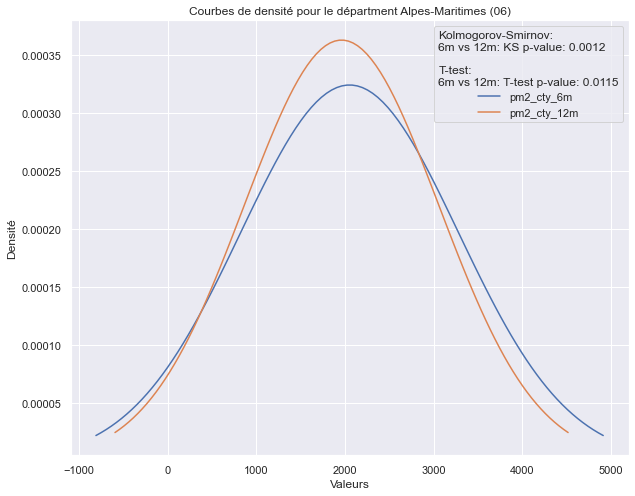

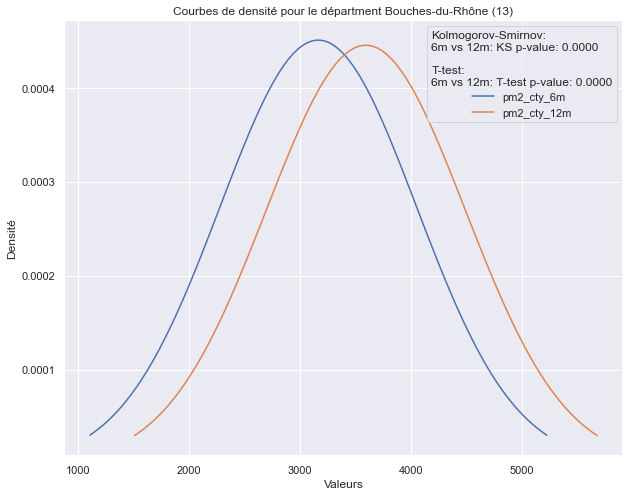

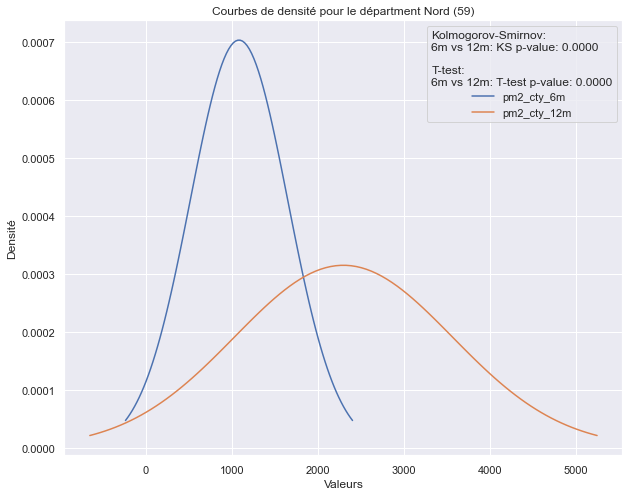

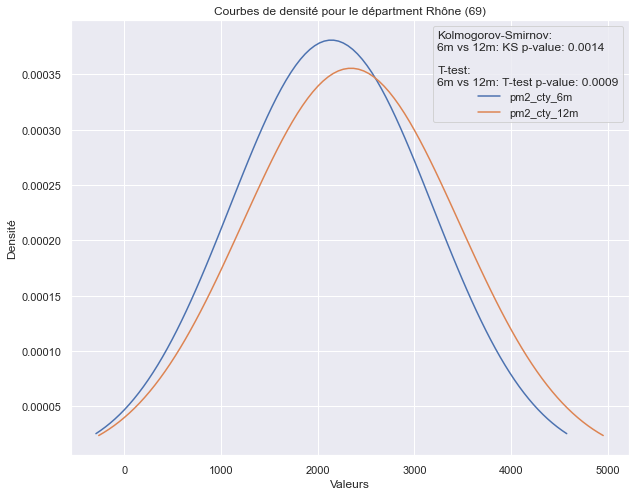

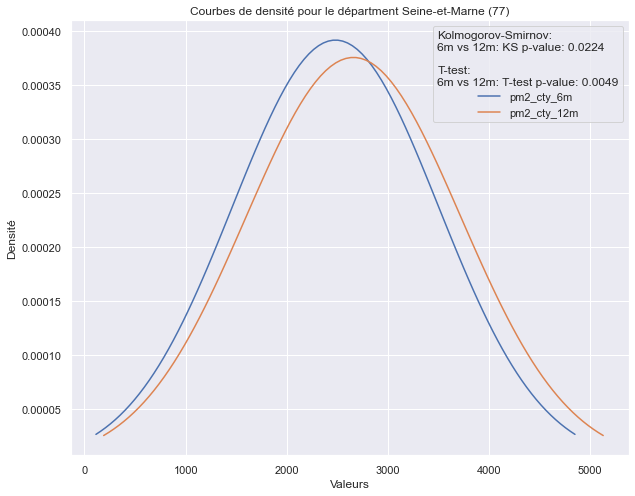

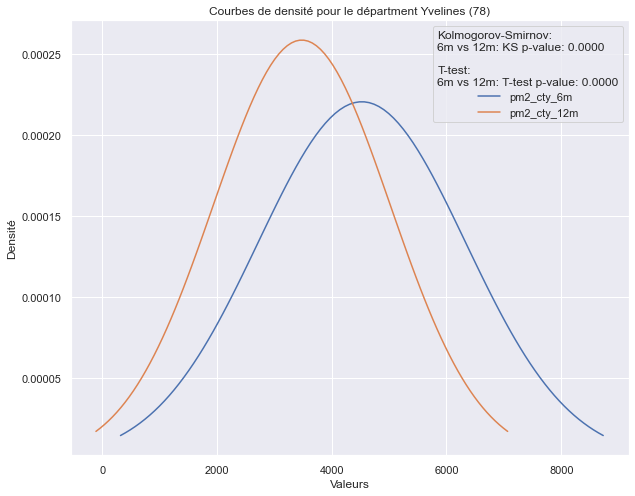

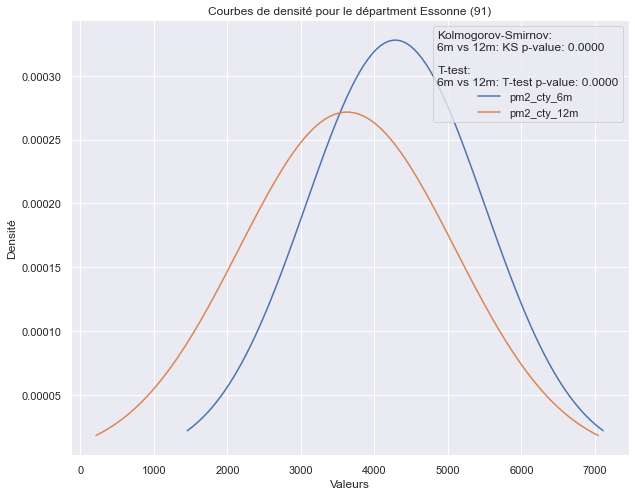

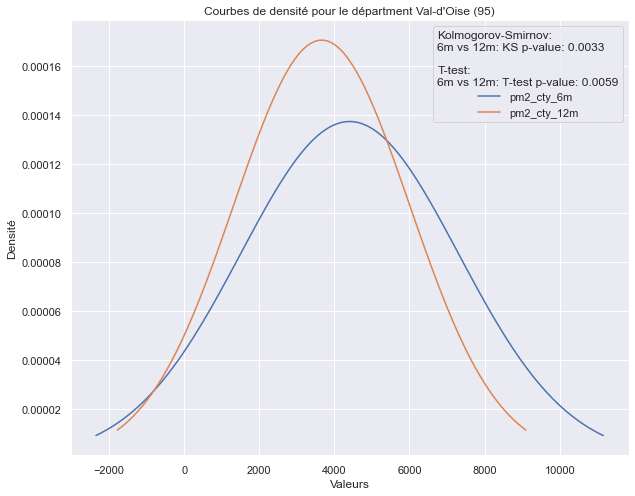

In [8]:
# TODO : ajouter les différentes images au latex, chemin : N:/uflujek/prix_m2/images/image_APT_{geo}.png

requete_sql = f"""
SELECT  *
FROM table_final
WHERE DIC_NAME LIKE '%cty_%_%m' AND CD_TYP_BIEN = 'APT'"""
df = ps.sqldf(requete_sql, locals())

df = df[df['DIC_NAME'].str.contains('6m|12m')]
cd_typ_bien_values = df['CD_TYP_BIEN'].unique()

for typ_bien in cd_typ_bien_values:
    df_typ_bien = df[df['CD_TYP_BIEN'] == typ_bien]
    geo_values = df_typ_bien['VAL_MAILLE_GEO'].unique()

    for geo in geo_values:
        value = df[df['VAL_MAILLE_GEO'] == geo]['nom_département'].values
        fig, ax = plt.subplots(figsize=(10, 8))
        
        temp_df = df_typ_bien[df_typ_bien['VAL_MAILLE_GEO'] == geo]
        
        dic_names = temp_df['DIC_NAME'].unique()
        
        p_values_ks = []
        p_values_t = []

        for dic_name in dic_names:
            df_geo_dic = temp_df[temp_df['DIC_NAME'] == dic_name]
            if df_geo_dic.empty:
                print(f"Données manquantes pour la combinaison DIC_NAME={dic_name} et VAL_MAILLE_GEO={geo}")
                continue
            
            if '6m' in dic_name:
                mean = df_geo_dic['MEAN'].values[0]
            elif '12m' in dic_name:
                mean = df_geo_dic['mean_12_m'].values[0]
            
            std = df_geo_dic['STD'].values[0]

            if np.isnan(mean) or np.isnan(std) or std <= 0:
                print(f"Paramètres de distribution invalides pour DIC_NAME={dic_name} et VAL_MAILLE_GEO={geo}")
                continue
            
            
            dist = stats.norm(loc=mean, scale=std)
            sample = dist.rvs(size=1000)
            if np.isnan(sample).any():
                print(f"Données manquantes dans l'échantillon généré pour DIC_NAME={dic_name} et VAL_MAILLE_GEO={geo}")
                continue
            x = np.linspace(dist.ppf(0.01), dist.ppf(0.99), 100)
            y = dist.pdf(x)  

            label = dic_name[2:] if dic_name.startswith('__') else dic_name
            
            ax.plot(x, y, label=label)
            
            for i in range(len(dic_names)):
                for j in range(i + 1, len(dic_names)):
                    dic_name1 = dic_names[i]
                    dic_name2 = dic_names[j]
                    
                    if df_geo_dic['MEAN'].isnull().any():
                        print(f"Données manquantes pour la combinaison DIC_NAME={dic_name1} et DIC_NAME={dic_name2} et VAL_MAILLE_GEO={geo}")
                        continue

                    df_geo_dic1 = temp_df[temp_df['DIC_NAME'] == dic_name1]
                    df_geo_dic2 = temp_df[temp_df['DIC_NAME'] == dic_name2]
                    
                    mean1 = df_geo_dic1['MEAN'].values[0]
                    std1 = df_geo_dic1['STD'].values[0]
                    mean2 = df_geo_dic2['MEAN'].values[0]
                    std2 = df_geo_dic2['STD'].values[0]
                    if np.isnan(mean1) or np.isnan(std1) or np.isnan(mean2) or np.isnan(std2) or std1 <= 0 or std2 <= 0:
                        print(f"Paramètres de distribution invalides pour DIC_NAME={dic_name1}, DIC_NAME={dic_name2} et VAL_MAILLE_GEO={geo}")
                        continue

                    sample1 = np.random.normal(loc=mean1, scale=std1, size=1000)
                    sample2 = np.random.normal(loc=mean2, scale=std2, size=1000)
                    
                    if np.isnan(sample1).any() or np.isnan(sample2).any():
                        print(f"Données manquantes dans les échantillons générés pour DIC_NAME={dic_name1}, DIC_NAME={dic_name2} et VAL_MAILLE_GEO={geo}")
                        continue
                    
                    d, p_ks = stats.ks_2samp(sample1, sample2)

                    t, p_t = stats.ttest_rel(sample1, sample2)
                
                    label1 = dic_name1[2:] if dic_name1.startswith('__') else dic_name1
                    label2 = dic_name2[2:] if dic_name2.startswith('__') else dic_name2
                    p_values_ks.append(p_ks)
                    p_values_t.append(p_t)
        p_values_ks_str = ', '.join([f'{p:.4f}' for p in p_values_ks])
        p_values_t_str = ', '.join([f'{p:.4f}' for p in p_values_t])
        
        leg_text_ks = '\n'.join([f'{dic_names[i].split("_")[-1]} vs {dic_names[j].split("_")[-1]}: KS p-value: {p_values_ks[i*(len(dic_names)-i-1)//2+j-i-1]:.4f}' for i in range(len(dic_names)) for j in range(i+1, len(dic_names))])
        leg_text_t = '\n'.join([f'{dic_names[i].split("_")[-1]} vs {dic_names[j].split("_")[-1]}: T-test p-value: {p_values_t[i*(len(dic_names)-i-1)//2+j-i-1]:.4f}' for i in range(len(dic_names)) for j in range(i+1, len(dic_names))])

        ax.set_title(f'Courbes de densité pour le départment {value[0]} ({geo})')
        ax.set_xlabel('Valeurs')
        ax.set_ylabel('Densité')
        ax.legend(title=f'Kolmogorov-Smirnov:\n{leg_text_ks}\n\nT-test:\n{leg_text_t}', loc='upper right')

        plt.savefig(f'N:/uflujek/prix_m2/images/image_APT_{geo}.png')

In [9]:
# TODO : Tableau représentant la variation et l'état des prix par type de bien dans différents départements : pivot_df

results_df = pd.DataFrame(columns=['geo', 'p-value < 0.05', 'variation'])

import itertools
requete_sql = f"""
SELECT  *
FROM table_final
WHERE DIC_NAME LIKE '%cty_6m' OR DIC_NAME LIKE '%cty_12m'"""
df = ps.sqldf(requete_sql, locals())
geo_values = df['VAL_MAILLE_GEO'].unique()
results_df = pd.DataFrame(columns=['geo', 'p-value < 0.05', 'variation', 'date', 'CD_TYP_BIEN', 'status'])

for geo in geo_values:
    geo_df = df[df['VAL_MAILLE_GEO'] == geo]
    value = df[df['VAL_MAILLE_GEO'] == geo]['nom_département'].values

    # Recupération des couples de 'DIC_NAME' et 'CD_TYP_BIEN' uniques
    unique_pairs = geo_df[['DIC_NAME', 'CD_TYP_BIEN']].drop_duplicates().values

    # Pour chaque paire de 'DIC_NAME' et 'CD_TYP_BIEN'
    for pair1, pair2 in itertools.combinations(unique_pairs, 2):
        dic_name1, cd_typ_bien1 = pair1
        dic_name2, cd_typ_bien2 = pair2

        # Comparer seulement si 'CD_TYP_BIEN' est le même et dic_name différent (donc 6 m vs 12m)
        if cd_typ_bien1 == cd_typ_bien2 and dic_name1 != dic_name2:
            df1 = geo_df[(geo_df['DIC_NAME'] == dic_name1) & (geo_df['CD_TYP_BIEN'] == cd_typ_bien1)]
            df2 = geo_df[(geo_df['DIC_NAME'] == dic_name2) & (geo_df['CD_TYP_BIEN'] == cd_typ_bien2)]
            
            mean1 = df1['MEAN'].values[0]
            std1 = df1['STD'].values[0]
            mean2 = df2['mean_12_m'].values[0]
            std2 = df2['STD'].values[0]

            if not np.isnan(mean1) and not np.isnan(std1) and std1 > 0 and \
                not np.isnan(mean2) and not np.isnan(std2) and std2 > 0:
                np.random.seed(123)
                sample1 = np.random.normal(loc=mean1, scale=std1, size=1000)
                sample2 = np.random.normal(loc=mean2, scale=std2, size=1000)

                if not np.isnan(sample1).any() and not np.isnan(sample2).any():
                    t, p_t = stats.ttest_rel(sample1, sample2)
                    d, p_ks = stats.ks_2samp(sample1, sample2)

                    date = f'{dic_name1.split("_")[-1]} vs {dic_name2.split("_")[-1]}'

                    if p_t < 0.008 and mean1 / mean2 < 1:
                        status = 'baisse significative'
                    elif p_t < 0.008 and mean1 / mean2 > 1:
                        status = 'hausse significative'
                    else:
                        status = 'stable'

                    results_df = results_df.append({
                        'nom' : value[0],
                        'numéro': geo,
                        'p-value < 0.05': p_t < 0.05,  
                        'variation': str(((mean1 / mean2 -1)*100).round(2)) +'%' if mean2 != 0 else np.nan,  
                        'date': date,  
                        'CD_TYP_BIEN': cd_typ_bien1, 
                        'status': status
                    }, ignore_index=True)

results_df= results_df[(results_df['date'] == '6m vs 12m') & (results_df['CD_TYP_BIEN']!= 'ALL')]
pivot_df = results_df.pivot(index=[ 'nom', 'numéro'], columns='CD_TYP_BIEN', values=['variation', 'status'])

print(pivot_df)


                        variation                         status  \
CD_TYP_BIEN                   APT      MAI                   APT   
nom              numéro                                            
Alpes-Maritimes  06         4.62%    9.54%                stable   
Bouches-du-Rhône 13       -11.91%  -45.24%  baisse significative   
Essonne          91        18.07%   -0.19%  hausse significative   
Nord             59       -52.79%   16.12%  baisse significative   
Rhône            69        -8.67%  -10.22%  baisse significative   
Seine-et-Marne   77        -6.68%    0.13%  baisse significative   
Val-d'Oise       95         20.3%  -19.34%  hausse significative   
Yvelines         78        30.07%   -2.42%  hausse significative   

                                               
CD_TYP_BIEN                               MAI  
nom              numéro                        
Alpes-Maritimes  06      hausse significative  
Bouches-du-Rhône 13      baisse significative  
Essonne    

## IMPORT

In [10]:
SERVEUR = 'ISIS'
DATABASE = 'BIENS'
SCHEMA = 'dbo'




PROD_PWD = 'Est1mat1on@b1ens_Dev%'
PROD_ID = 'Ebiens_Batch'



conn = pyodbc.connect('DRIVER={SQL Server};'
                                f'SERVER={SERVEUR};'
                                f'DATABASE={DATABASE};'
                                f'UID={PROD_ID};'
                                f'PWD={PROD_PWD};')
df_prix_m2 = pd.read_sql_query(
    f"""SELECT DISTINCT *
    FROM BIENS.dbo.PRIX_M2
    WHERE MAILLE_GEO = 'CITY' """
    ,conn)

In [11]:
df = pd.read_excel(r'N:\uflujek\Commune_france.xlsx', header=2)
df['Commune'] = df['Commune'].apply(lambda x: x.upper().replace('-', ' ') if pd.notnull(x) else np.nan)
df_prix_m2 = df.merge(df_prix_m2, left_on='Commune', right_on='VAL_MAILLE_GEO', how='right')



In [12]:
requete_sql = """
SELECT  Rang,  Commune, DIC_NAME, CD_TYP_BIEN, VAL_MAILLE_GEO, DT_MAJ_PM2, NB_BIENS, MEAN, STD, MEDIAN, D1, Q1, Q3, D9
FROM df_prix_m2
WHERE DIC_NAME LIKE '%cty_%_%m' AND Rang IS NOT NULL"""
df_prix_m2 = ps.sqldf(requete_sql, locals())

## Prix au m² des plus grandes villes françaises

### Cartes

In [13]:
# TODO : ajouter les cartes au latex, chemin : N:\\uflujek\\prix_m2\\ma_carte_prix_m2_villes_{type_bien}.html
# Elles sont créées à la fin du code

### Tableau récapitulatif

In [14]:
# TODO : insérer Tableau des prix par mètre carré selon Crédit Logement : df_final

df_final = pd.DataFrame()
list_tables = [] 
for k in range(n_plus_grandes_villes):
    requete_sql = f"""
    SELECT  *
    FROM df_prix_m2
    WHERE Rang = '{k}' """
    df_prix_m2_ville = ps.sqldf(requete_sql, locals())

    df = df_prix_m2_ville
    
    df_3m = df[(df['DIC_NAME'] == '__pm2_cty_3m') & (df['CD_TYP_BIEN'] != 'ALL') | 
                (df['DIC_NAME'] == '__pm2_cty_comp_3m') & (df['CD_TYP_BIEN'] == 'ALL')]
    df_6m = df[((df['DIC_NAME'] == '__pm2_cty_6m') & (df['CD_TYP_BIEN'] != 'ALL')) | 
                ((df['DIC_NAME'] == '__pm2_cty_comp_6m') & (df['CD_TYP_BIEN'] == 'ALL'))]
    df_3m = df_3m.rename(columns={'MEAN': 'mean_3m', 'NB_BIENS': 'nb_bien_3m'})
    df_6m = df_6m.rename(columns={'MEAN': 'mean_6m_3m', 'NB_BIENS': 'nb_bien_6m'})
    df_merged = pd.merge(df_3m, df_6m, on=['Commune', 'CD_TYP_BIEN'], how='inner')
    df_merged['mean_6_m'] = (df_merged['mean_6m_3m'] * (df_merged['nb_bien_3m'] + df_merged['nb_bien_6m']) - df_merged['nb_bien_3m'] * df_merged['mean_3m']) / df_merged['nb_bien_6m']
    df_6m_merged = df_merged[((df_merged['DIC_NAME_y'] == '__pm2_cty_6m') | (df_merged['DIC_NAME_y'] == '__pm2_cty_comp_6m'))]
    df_prix_m2_ville = pd.merge(df_prix_m2_ville, df_6m_merged[['Commune', 'CD_TYP_BIEN', 'mean_6_m']], on=['Commune', 'CD_TYP_BIEN'], how='left')
    df_prix_m2_ville['mean_6_m'] = df_prix_m2_ville['mean_6_m'].where(df_prix_m2_ville['DIC_NAME'].str.endswith('6m'), np.nan)
    df_6m = df[(df['DIC_NAME'] == '__pm2_cty_6m') & (df['CD_TYP_BIEN'] != 'ALL') | 
                (df['DIC_NAME'] == '__pm2_cty_comp_6m') & (df['CD_TYP_BIEN'] == 'ALL')]
    df_12m = df[((df['DIC_NAME'] == '__pm2_cty_12m') & (df['CD_TYP_BIEN'] != 'ALL')) | 
                ((df['DIC_NAME'] == '__pm2_cty_comp_12m') & (df['CD_TYP_BIEN'] == 'ALL'))]
    df_6m = df_6m.rename(columns={'MEAN': 'mean_6m', 'NB_BIENS': 'nb_bien_6m'})
    df_12m = df_12m.rename(columns={'MEAN': 'mean_12m_6m', 'NB_BIENS': 'nb_bien_12m'})
    df_merged = pd.merge(df_6m, df_12m, on=['Commune', 'CD_TYP_BIEN'], how='inner')
    df_merged['mean_12_m'] = (df_merged['mean_12m_6m'] * (df_merged['nb_bien_6m'] + df_merged['nb_bien_12m']) - df_merged['nb_bien_6m'] * df_merged['mean_6m']) / df_merged['nb_bien_12m']
    df_12m_merged = df_merged[((df_merged['DIC_NAME_y'] == '__pm2_cty_12m') | (df_merged['DIC_NAME_y'] == '__pm2_cty_comp_12m'))]
    df_prix_m2_ville = pd.merge(df_prix_m2_ville, df_12m_merged[['Commune', 'CD_TYP_BIEN', 'mean_12_m']], on=['Commune', 'CD_TYP_BIEN'], how='left')
    df_prix_m2_ville['mean_12_m'] = df_prix_m2_ville['mean_12_m'].where(df_prix_m2_ville['DIC_NAME'].str.endswith('12m'), np.nan)

    table = df_prix_m2_ville[['Commune', 'CD_TYP_BIEN', 'mean_6_m', 'mean_12_m', 'DIC_NAME', 'MEAN', 'NB_BIENS', 'VAL_MAILLE_GEO', 'STD']]
    list_tables.append(table)




    def create_pivot(df, dic_name, value_column, index='Commune', columns='CD_TYP_BIEN'):
        unique_cols = df[columns].unique()
        pivot = pd.DataFrame(columns=pd.MultiIndex.from_product([[f'prix_m2_{dic_name}'], unique_cols]), index=df[index].unique())
        subset_df = df[df['DIC_NAME'].str.contains(dic_name)]
        if not subset_df[value_column].isna().all():
            pivot_temp = subset_df.pivot_table(index=index, columns=columns, values=value_column)
            pivot_temp.columns = pd.MultiIndex.from_product([[f'prix_m2_{dic_name}'], pivot_temp.columns])
            pivot.update(pivot_temp)

        for col in pivot.columns:
            pivot[col] = pivot[col].apply(lambda x: f"{x:,.0f}".replace(',', ' ') + ' €' if pd.notna(x) else '-')
            pivot.index = pivot.index.str.capitalize()

        return pivot



    pivot_3m = create_pivot(df_prix_m2_ville, '3m', 'MEAN')
    pivot_6m = create_pivot(df_prix_m2_ville, '6m', 'mean_6_m')
    pivot_12m = create_pivot(df_prix_m2_ville, '12m', 'mean_12_m')

    df_new = pd.concat([pivot_3m, pivot_6m, pivot_12m], axis=1)
    
    if not df_new.empty:
        df_new = df_new.round(0)
        df_final = pd.concat([df_final, df_new], axis=0)


table_final = pd.concat(list_tables, ignore_index=True)
############## affichage ##############
df_final.columns = df_final.columns.set_levels(['12 mois' if x == 'prix_m2_12m' else x for x in df_final.columns.levels[0]], level=0)
df_final.columns = df_final.columns.set_levels(['3 mois' if x == 'prix_m2_3m' else x for x in df_final.columns.levels[0]], level=0)
df_final.columns = df_final.columns.set_levels(['6 mois' if x == 'prix_m2_6m' else x for x in df_final.columns.levels[0]], level=0)
cols_non_12m = [col for col in df_final.columns if col[0] != '12 mois']
cols_12m = [col for col in df_final.columns if col[0] == '12 mois']
ordered_cols = cols_non_12m + cols_12m
df_final = df_final[ordered_cols]
print(df_final)

               3 mois                       6 mois                     \
                  ALL       APT      MAI       ALL       APT      MAI   
Paris        12 093 €  12 093 €      NaN  12 827 €  12 827 €      NaN   
Toulouse      4 304 €   4 309 €  4 721 €   4 103 €   4 047 €  4 354 €   
Nice          5 112 €   5 112 €  5 351 €   5 318 €   5 300 €  6 548 €   
Nantes        4 739 €   4 578 €  4 430 €   4 068 €   4 000 €  4 693 €   
Montpellier   4 310 €   4 275 €  4 582 €   4 125 €   4 037 €  4 800 €   
Strasbourg    4 066 €   4 025 €  4 771 €   3 536 €   3 613 €  4 112 €   
Bordeaux      4 720 €   4 616 €  5 662 €   5 085 €   4 944 €  5 527 €   
Lille         3 921 €   4 105 €  2 810 €   3 910 €   4 159 €  2 818 €   
Rennes        3 922 €   3 922 €  5 684 €   4 706 €   4 718 €  5 684 €   
Reims         3 100 €   3 136 €  2 684 €   3 528 €   3 823 €  2 967 €   
Toulon        3 410 €   3 263 €  4 381 €   3 182 €   3 032 €  5 680 €   

              12 mois                     
       

In [15]:
# TODO : ajouter Tableau comparatif des prix par mètre carré selon Crédit Logement (3 mois) et Meilleurs Agents : result

df_MA = pd.read_excel(r'N:\uflujek\table_rapport\Prix_m2\prix_MA_ville.xlsx')
df_MA.drop(columns=['Loyer m2 moyen', 'Loyer m2 moyen.1'], inplace=True)
df_MA.set_index('Ville', inplace=True)
result = df_MA.merge(df_final["3 mois"], left_index=True, right_index=True)

columns_to_rename = {
    result.columns[0]: 'Appartment',
    result.columns[1]: 'Maison',
    result.columns[3]: 'Appartement ',
    result.columns[4]: 'Maison '
}

result.rename(columns=columns_to_rename, inplace=True)



result = result[['Appartment', 'Maison', 'Appartement ', 'Maison ']]




header = pd.MultiIndex.from_tuples([
    ('Meilleur Agent', 'Appartement'),
    ('Meilleur Agent', 'Maison'),
    ('Crédit Logement', 'Appartement '),
    ('Crédit Logement', 'Maison ')
])
result.columns = header

print(result)


            Meilleur Agent           Crédit Logement         
               Appartement    Maison    Appartement   Maison 
Paris             10 078 €  10 748 €        12 093 €      NaN
Toulouse           3 688 €   4 162 €         4 309 €  4 721 €
Nice               5 153 €   6 279 €         5 112 €  5 351 €
Nantes             3 849 €   4 726 €         4 578 €  4 430 €
Strasbourg         4 001 €   3 665 €         4 025 €  4 771 €
Montpellier        3 526 €   4 636 €         4 275 €  4 582 €
Bordeaux           4 623 €   5 500 €         4 616 €  5 662 €
Lille              3 646 €   3 333 €         4 105 €  2 810 €
Rennes             4 059 €   5 165 €         3 922 €  5 684 €
Reims              2 580 €   2 975 €         3 136 €  2 684 €
Toulon             3 236 €   4 238 €         3 263 €  4 381 €


### Evolution du prix au m²

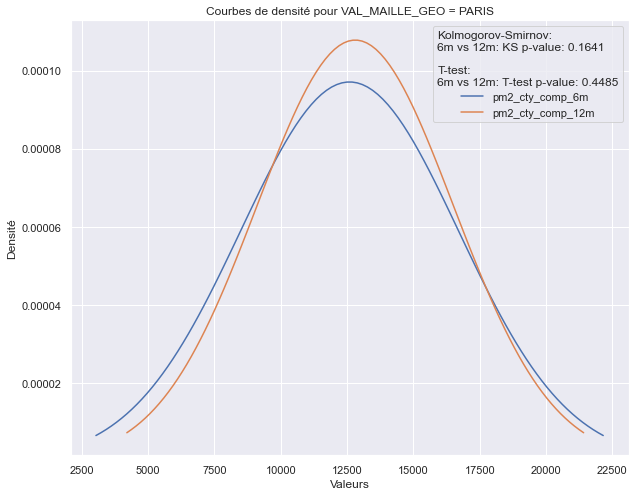

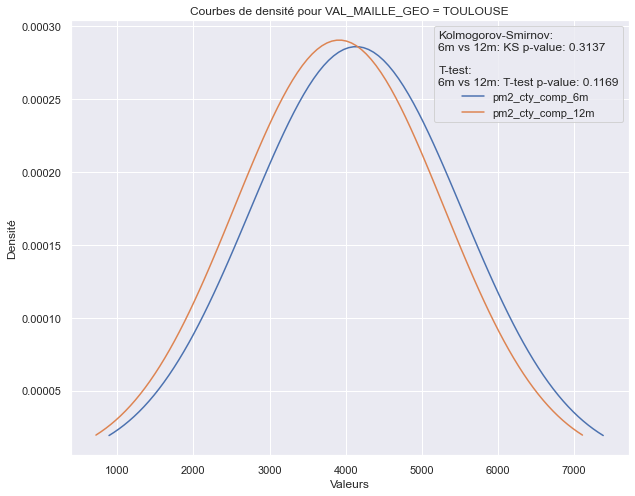

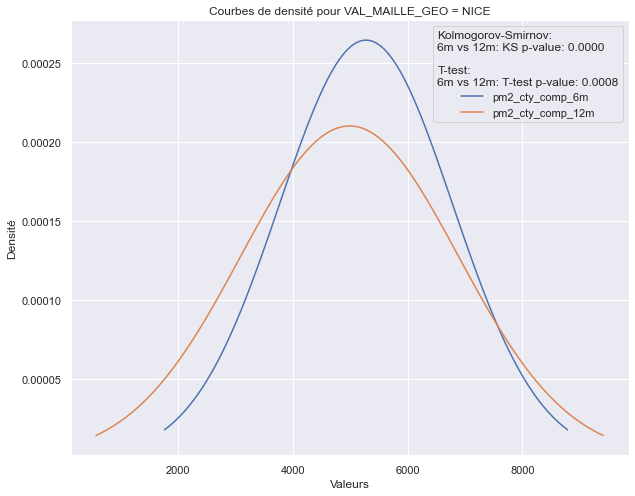

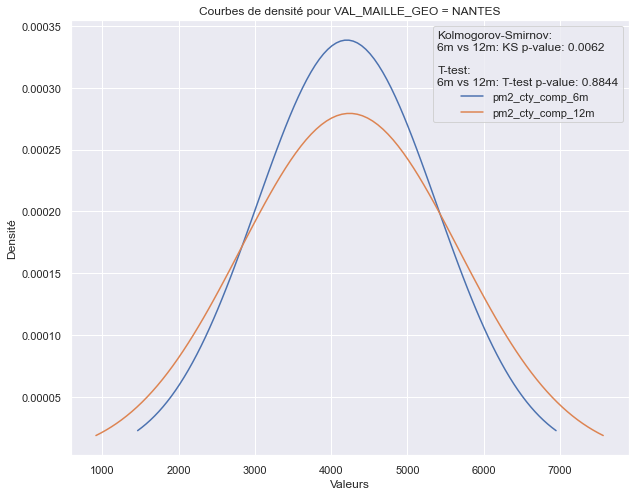

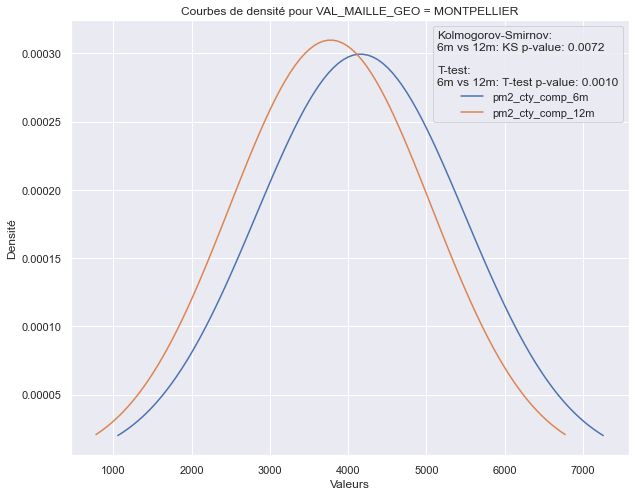

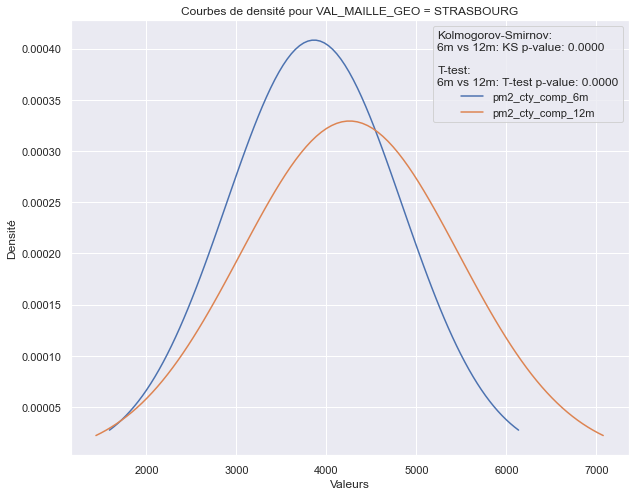

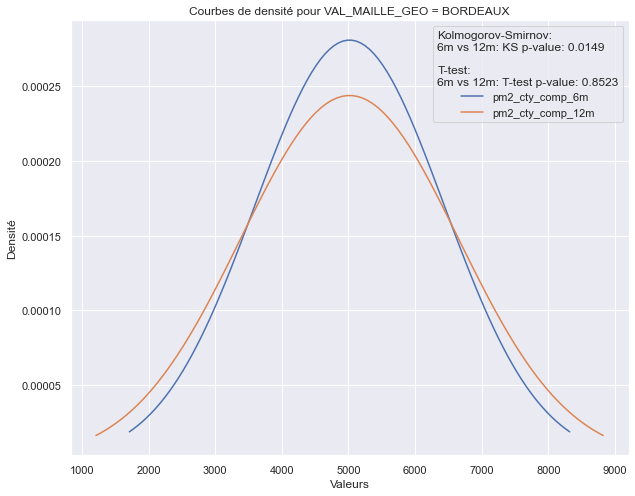

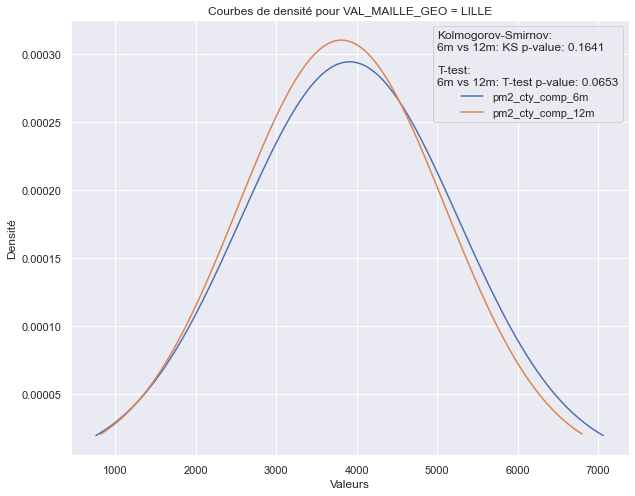

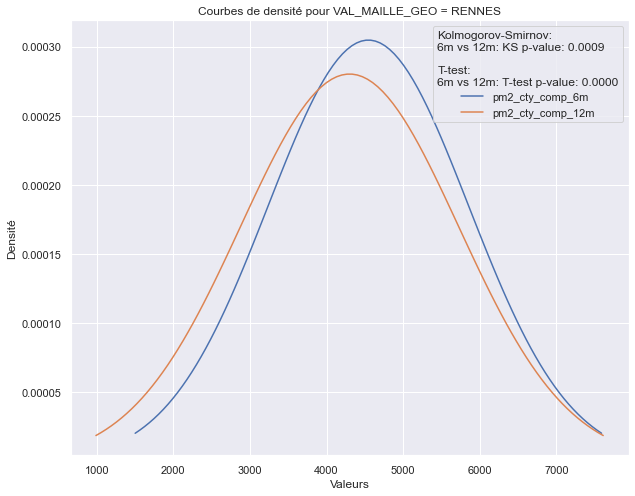

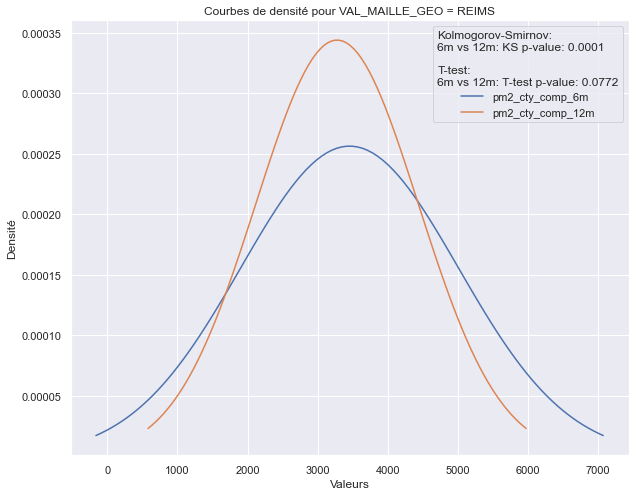

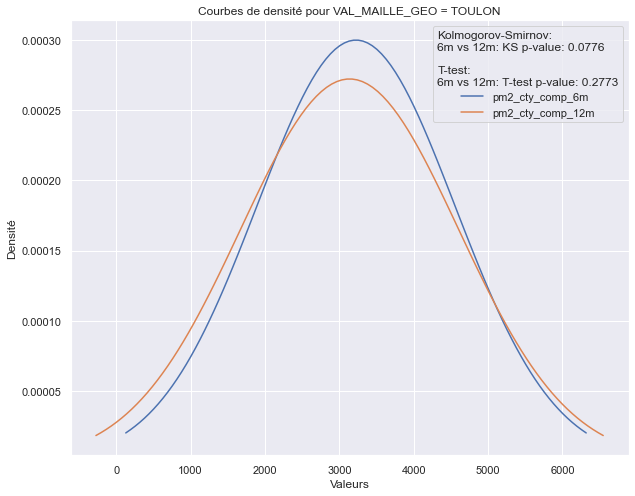

In [16]:


requete_sql = f"""
SELECT  *
FROM table_final
WHERE DIC_NAME LIKE '%cty_comp_%m'"""
df = ps.sqldf(requete_sql, locals())


df = df[df['DIC_NAME'].str.contains('6m|12m')]

cd_typ_bien_values = df['CD_TYP_BIEN'].unique()

for typ_bien in cd_typ_bien_values:

    df_typ_bien = df[df['CD_TYP_BIEN'] == typ_bien]

    geo_values = df_typ_bien['VAL_MAILLE_GEO'].unique()
    
    for geo in geo_values:
        
        fig, ax = plt.subplots(figsize=(10, 8))
        
        temp_df = df_typ_bien[df_typ_bien['VAL_MAILLE_GEO'] == geo]
        
        dic_names = temp_df['DIC_NAME'].unique()
        
        p_values_ks = []
        p_values_t = []

        for dic_name in dic_names:
            df_geo_dic = temp_df[temp_df['DIC_NAME'] == dic_name]
        
            # Vérifier si les données sont manquantes pour cette combinaison DIC_NAME et VAL_MAILLE_GEO
            if df_geo_dic.empty:
                print(f"Données manquantes pour la combinaison DIC_NAME={dic_name} et VAL_MAILLE_GEO={geo}")
                continue
            
            # Récupérer la moyenne et l'écart-type correspondants
            if '6m' in dic_name:
                mean = df_geo_dic['MEAN'].values[0]
            elif '12m' in dic_name:
                mean = df_geo_dic['mean_12_m'].values[0]
            
            std = df_geo_dic['STD'].values[0]
            
            # Vérifier si les paramètres de la distribution sont valides
            if np.isnan(mean) or np.isnan(std) or std <= 0:
                print(f"Paramètres de distribution invalides pour DIC_NAME={dic_name} et VAL_MAILLE_GEO={geo}")
                continue
            
            # Créer la distribution normale ajustée
            dist = stats.norm(loc=mean, scale=std)
            
            # Générer un échantillon à partir de la distribution normale
            sample = dist.rvs(size=1000)

            if np.isnan(sample).any():
                print(f"Données manquantes dans l'échantillon généré pour DIC_NAME={dic_name} et VAL_MAILLE_GEO={geo}")
                continue
            
            x = np.linspace(dist.ppf(0.01), dist.ppf(0.99), 100)
            y = dist.pdf(x) 
            label = dic_name[2:] if dic_name.startswith('__') else dic_name
            
            ax.plot(x, y, label=label)
            
            # Effectuer le test de Kolmogorov-Smirnov entre les paires de DIC_NAME
            for i in range(len(dic_names)):
                for j in range(i + 1, len(dic_names)):
                    dic_name1 = dic_names[i]
                    dic_name2 = dic_names[j]
                    
                    if df_geo_dic['MEAN'].isnull().any():
                        print(f"Données manquantes pour la combinaison DIC_NAME={dic_name1} et DIC_NAME={dic_name2} et VAL_MAILLE_GEO={geo}")
                        continue
                    
                    df_geo_dic1 = temp_df[temp_df['DIC_NAME'] == dic_name1]
                    df_geo_dic2 = temp_df[temp_df['DIC_NAME'] == dic_name2]
                   
                    mean1 = df_geo_dic1['MEAN'].values[0]
                    std1 = df_geo_dic1['STD'].values[0]
                    mean2 = df_geo_dic2['MEAN'].values[0]
                    std2 = df_geo_dic2['STD'].values[0]
                    if np.isnan(mean1) or np.isnan(std1) or np.isnan(mean2) or np.isnan(std2) or std1 <= 0 or std2 <= 0:
                        print(f"Paramètres de distribution invalides pour DIC_NAME={dic_name1}, DIC_NAME={dic_name2} et VAL_MAILLE_GEO={geo}")
                        continue
        
                    sample1 = np.random.normal(loc=mean1, scale=std1, size=1000)
                    sample2 = np.random.normal(loc=mean2, scale=std2, size=1000)
                    
                    if np.isnan(sample1).any() or np.isnan(sample2).any():
                        print(f"Données manquantes dans les échantillons générés pour DIC_NAME={dic_name1}, DIC_NAME={dic_name2} et VAL_MAILLE_GEO={geo}")
                        continue
                    
                    # Effectuer le test de Kolmogorov-Smirnov à deux échantillons
                    d, p_ks = stats.ks_2samp(sample1, sample2)
                    
                    # Effectuer le test de Student t indépendant
                    t, p_t = stats.ttest_rel(sample1, sample2)
                
                    label1 = dic_name1[2:] if dic_name1.startswith('__') else dic_name1
                    label2 = dic_name2[2:] if dic_name2.startswith('__') else dic_name2
                    
                    p_values_ks.append(p_ks)
                    p_values_t.append(p_t)
        
        p_values_ks_str = ', '.join([f'{p:.4f}' for p in p_values_ks])
        p_values_t_str = ', '.join([f'{p:.4f}' for p in p_values_t])
        
        leg_text_ks = '\n'.join([f'{dic_names[i].split("_")[-1]} vs {dic_names[j].split("_")[-1]}: KS p-value: {p_values_ks[i*(len(dic_names)-i-1)//2+j-i-1]:.4f}' for i in range(len(dic_names)) for j in range(i+1, len(dic_names))])
        leg_text_t = '\n'.join([f'{dic_names[i].split("_")[-1]} vs {dic_names[j].split("_")[-1]}: T-test p-value: {p_values_t[i*(len(dic_names)-i-1)//2+j-i-1]:.4f}' for i in range(len(dic_names)) for j in range(i+1, len(dic_names))])

        ax.set_title(f'Courbes de densité pour VAL_MAILLE_GEO = {geo}')
        ax.set_xlabel('Valeurs')
        ax.set_ylabel('Densité')
        ax.legend(title=f'Kolmogorov-Smirnov:\n{leg_text_ks}\n\nT-test:\n{leg_text_t}', loc='upper right')

        plt.savefig(f'N:/uflujek/prix_m2/images/image_{typ_bien}_{geo}_2.png')

In [17]:
results_df = pd.DataFrame(columns=['geo', 'p-value < 0.05', 'variation'])

import itertools
requete_sql = f"""
SELECT  *
FROM table_final
WHERE DIC_NAME LIKE '%cty_%_%m'"""
df = ps.sqldf(requete_sql, locals())
geo_values = df['VAL_MAILLE_GEO'].unique()
results_df = pd.DataFrame(columns=['geo', 'p-value < 0.05', 'variation', 'date', 'CD_TYP_BIEN', 'status'])

for geo in geo_values:
    geo_df = df[df['VAL_MAILLE_GEO'] == geo]

    # Recupération des couples de 'DIC_NAME' et 'CD_TYP_BIEN' uniques
    unique_pairs = geo_df[['DIC_NAME', 'CD_TYP_BIEN']].drop_duplicates().values

    # Pour chaque paire de 'DIC_NAME' et 'CD_TYP_BIEN'
    for pair1, pair2 in itertools.combinations(unique_pairs, 2):
        dic_name1, cd_typ_bien1 = pair1
        dic_name2, cd_typ_bien2 = pair2

        # Comparer seulement si 'CD_TYP_BIEN' est le même
        if cd_typ_bien1 == cd_typ_bien2:
            df1 = geo_df[(geo_df['DIC_NAME'] == dic_name1) & (geo_df['CD_TYP_BIEN'] == cd_typ_bien1)]
            df2 = geo_df[(geo_df['DIC_NAME'] == dic_name2) & (geo_df['CD_TYP_BIEN'] == cd_typ_bien2)]
            
            mean1 = df1['MEAN'].values[0]
            std1 = df1['STD'].values[0]
            mean2 = df2['mean_12_m'].values[0]
            std2 = df2['STD'].values[0]

            if not np.isnan(mean1) and not np.isnan(std1) and std1 > 0 and \
                not np.isnan(mean2) and not np.isnan(std2) and std2 > 0:
                np.random.seed(123)
                sample1 = np.random.normal(loc=mean1, scale=std1, size=1000)
                sample2 = np.random.normal(loc=mean2, scale=std2, size=1000)

                if not np.isnan(sample1).any() and not np.isnan(sample2).any():
                    t, p_t = stats.ttest_rel(sample1, sample2)
                    d, p_ks = stats.ks_2samp(sample1, sample2)

                    date = f'{dic_name1.split("_")[-1]} vs {dic_name2.split("_")[-1]}'

                    if p_t < 0.01 and mean1 / mean2 < 1:
                        status = 'baisse significative'
                    elif p_t < 0.01 and mean1 / mean2 > 1:
                        status = 'hausse significative'
                    else:
                        status = 'stable'

                    results_df = results_df.append({
                        'Ville': geo.capitalize(),
                        'p-value < 0.05': p_t < 0.05,  
                        'variation': str(((mean1 / mean2 -1)*100).round(2)) +'%' if mean2 != 0 else np.nan,  
                        'date': date,  
                        'CD_TYP_BIEN': cd_typ_bien1, 
                        'status': status
                    }, ignore_index=True)

results_df= results_df[(results_df['date'] == '6m vs 12m') & (results_df['CD_TYP_BIEN']!= 'ALL')]
pivot_df = results_df.pivot(index='Ville', columns='CD_TYP_BIEN', values=['variation', 'status'])

print(pivot_df)


            variation                         status                      
CD_TYP_BIEN       APT      MAI                   APT                   MAI
Ville                                                                     
Bordeaux        0.89%   -2.06%                stable                stable
Lille            3.3%  -10.51%                stable  baisse significative
Montpellier      9.7%    8.37%  hausse significative  hausse significative
Nantes          2.08%  -11.32%                stable  baisse significative
Nice            6.86%  -11.64%  hausse significative  baisse significative
Paris          -2.08%      NaN  baisse significative                   NaN
Reims          10.59%    -7.8%  hausse significative  baisse significative
Rennes          9.94%    2.96%  hausse significative                stable
Strasbourg     -8.69%   -9.31%  baisse significative  baisse significative
Toulon          6.66%    2.92%                stable                stable
Toulouse        6.25%    

In [18]:
df_final = pd.DataFrame()
list_tables = [] 
for k in range(50):
    requete_sql = f"""
    SELECT  *
    FROM df_prix_m2
    WHERE Rang = '{k}' """
    df_prix_m2_ville = ps.sqldf(requete_sql, locals())

    df = df_prix_m2_ville
    
    df_3m = df[(df['DIC_NAME'] == '__pm2_cty_3m') & (df['CD_TYP_BIEN'] != 'ALL') | 
                (df['DIC_NAME'] == '__pm2_cty_comp_3m') & (df['CD_TYP_BIEN'] == 'ALL')]
    df_6m = df[((df['DIC_NAME'] == '__pm2_cty_6m') & (df['CD_TYP_BIEN'] != 'ALL')) | 
                ((df['DIC_NAME'] == '__pm2_cty_comp_6m') & (df['CD_TYP_BIEN'] == 'ALL'))]
    df_3m = df_3m.rename(columns={'MEAN': 'mean_3m', 'NB_BIENS': 'nb_bien_3m'})
    df_6m = df_6m.rename(columns={'MEAN': 'mean_6m_3m', 'NB_BIENS': 'nb_bien_6m'})
    df_merged = pd.merge(df_3m, df_6m, on=['Commune', 'CD_TYP_BIEN'], how='inner')

    df_merged['mean_6_m'] = (df_merged['mean_6m_3m'] * (df_merged['nb_bien_3m'] + df_merged['nb_bien_6m']) - df_merged['nb_bien_3m'] * df_merged['mean_3m']) / df_merged['nb_bien_6m']


    df_6m_merged = df_merged[((df_merged['DIC_NAME_y'] == '__pm2_cty_6m') | (df_merged['DIC_NAME_y'] == '__pm2_cty_comp_6m'))]
    df_prix_m2_ville = pd.merge(df_prix_m2_ville, df_6m_merged[['Commune', 'CD_TYP_BIEN', 'mean_6_m']], on=['Commune', 'CD_TYP_BIEN'], how='left')
    df_prix_m2_ville['mean_6_m'] = df_prix_m2_ville['mean_6_m'].where(df_prix_m2_ville['DIC_NAME'].str.endswith('6m'), np.nan)
    df_6m = df[(df['DIC_NAME'] == '__pm2_cty_6m') & (df['CD_TYP_BIEN'] != 'ALL') | 
                (df['DIC_NAME'] == '__pm2_cty_comp_6m') & (df['CD_TYP_BIEN'] == 'ALL')]
    df_12m = df[((df['DIC_NAME'] == '__pm2_cty_12m') & (df['CD_TYP_BIEN'] != 'ALL')) | 
                ((df['DIC_NAME'] == '__pm2_cty_comp_12m') & (df['CD_TYP_BIEN'] == 'ALL'))]
    df_6m = df_6m.rename(columns={'MEAN': 'mean_6m', 'NB_BIENS': 'nb_bien_6m'})
    df_12m = df_12m.rename(columns={'MEAN': 'mean_12m_6m', 'NB_BIENS': 'nb_bien_12m'})
    df_merged = pd.merge(df_6m, df_12m, on=['Commune', 'CD_TYP_BIEN'], how='inner')
    df_merged['mean_12_m'] = (df_merged['mean_12m_6m'] * (df_merged['nb_bien_6m'] + df_merged['nb_bien_12m']) - df_merged['nb_bien_6m'] * df_merged['mean_6m']) / df_merged['nb_bien_12m']
    df_12m_merged = df_merged[((df_merged['DIC_NAME_y'] == '__pm2_cty_12m') | (df_merged['DIC_NAME_y'] == '__pm2_cty_comp_12m'))]
    df_prix_m2_ville = pd.merge(df_prix_m2_ville, df_12m_merged[['Commune', 'CD_TYP_BIEN', 'mean_12_m']], on=['Commune', 'CD_TYP_BIEN'], how='left')
    df_prix_m2_ville['mean_12_m'] = df_prix_m2_ville['mean_12_m'].where(df_prix_m2_ville['DIC_NAME'].str.endswith('12m'), np.nan)

    table = df_prix_m2_ville[['Commune', 'CD_TYP_BIEN', 'mean_6_m', 'mean_12_m', 'DIC_NAME', 'MEAN', 'NB_BIENS', 'VAL_MAILLE_GEO', 'STD']]
    list_tables.append(table)




    def create_pivot(df, dic_name, value_column, index='Commune', columns='CD_TYP_BIEN'):
        unique_cols = df[columns].unique()
        pivot = pd.DataFrame(columns=pd.MultiIndex.from_product([[f'prix_m2_{dic_name}'], unique_cols]), index=df[index].unique())
        subset_df = df[df['DIC_NAME'].str.contains(dic_name)]
        if not subset_df[value_column].isna().all():
            pivot_temp = subset_df.pivot_table(index=index, columns=columns, values=value_column)
            pivot_temp.columns = pd.MultiIndex.from_product([[f'prix_m2_{dic_name}'], pivot_temp.columns])
            pivot.update(pivot_temp)
            
        return pivot



    pivot_3m = create_pivot(df_prix_m2_ville, '3m', 'MEAN')
    pivot_6m = create_pivot(df_prix_m2_ville, '6m', 'mean_6_m')
    pivot_12m = create_pivot(df_prix_m2_ville, '12m', 'mean_12_m')

    df_new = pd.concat([pivot_3m, pivot_6m, pivot_12m], axis=1)
    
    if not df_new.empty:
        df_new = df_new.round(0)
        df_final = pd.concat([df_final, df_new], axis=0)


table_final = pd.concat(list_tables, ignore_index=True)

types_bien = ['ALL', 'APT', 'MAI']

for type_bien in types_bien:
    requete_sql = f"""
    SELECT  DISTINCT *
    FROM table_final
    WHERE CD_TYP_BIEN = '{type_bien}' AND DIC_NAME LIKE '%cty_%_%m' AND mean_12_m NOT NULL"""
    df = ps.sqldf(requete_sql, locals())
    df_geo = pd.read_csv(r'N:\uflujek\commune_france_gps.csv')
    df_geo['label'] = df_geo['label'].apply(lambda x: x.upper().replace('-', ' ') if pd.notnull(x) else np.nan)
    df= df_geo.merge(df, left_on='label', right_on='VAL_MAILLE_GEO', how='right')
    df['mean_12_m'] = df['mean_12_m'].astype(int)
    df = df[['label','latitude','longitude', 'mean_12_m']]
    df = df.dropna(subset=['latitude', 'longitude'])
    df = df.drop_duplicates(subset='label', keep='first')

    # Initialisez la carte centrée sur la France
    m = folium.Map(location=[46.603354, 1.888334], zoom_start=6)

    # Ajout des villes sur la carte
    for i in range(0, len(df)):
        folium.Marker([df.iloc[i]['latitude'], df.iloc[i]['longitude']], 
                      popup=folium.Popup(('Ville: ' + str(df.iloc[i]['label']).capitalize() + '<br>'
                                          'Prix au m²: ' + str(df.iloc[i]['mean_12_m']) + '€<br>'), 
                                         max_width=250)).add_to(m)

    m.save(f'N:\\uflujek\\prix_m2\\ma_carte_prix_m2_villes_{type_bien}.html')
    